In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 224
n_classes = 10

train_transforms = [transforms.RandomRotation(25), transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(), transforms.ToTensor()]
train_dataset = ImageFolder('data/imagenette2-320/train', transform = transforms.Compose(train_transforms))
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 8)

test_transforms = [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
test_dataset = ImageFolder('data/imagenette2-320/val', transform = transforms.Compose(test_transforms))
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, num_workers = 8)

Class: 7


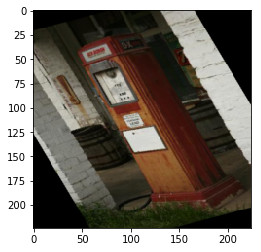

In [3]:
def visualizeFirstFromBatch(imgs):
    img = imgs[0].detach().cpu()
    plt.imshow(img.permute(1,2,0))
    plt.show()

def visualizeOne(dataloader):
    for x,y in dataloader:
        print('Class:', y[0].item())
        visualizeFirstFromBatch(x)
        break

visualizeOne(train_loader)

In [4]:
def trainOneEpoch(model, optimizer, criterion, train_loader, scheduler = None, epoch = 0, use_tqdm = False):
    losses = []
    train_dl = train_loader
    if use_tqdm: train_dl = tqdm(train_loader, desc = "Epoch: 0, Loss: 0")
    for x,y in train_dl:
        x,y = x.cuda(), y.cuda()

        predictions = model(x)
        loss = criterion(predictions, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None: scheduler.step()

        losses.append(loss.item())
        if use_tqdm: train_dl.set_description(f'Epoch: {epoch}, Loss: {loss.item():.3f}')
    return losses

def evalModel(model, criterion, test_loader, epoch = 0):
    losses = []
    accs = []
#     print('Evaluating...', end = '\r')
    
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.cuda(), y.cuda()
            
            predictions = model(x)
            loss = criterion(predictions, y)
            rounded_predictions = torch.argmax(predictions, dim = 1)
            acc = torch.sum(rounded_predictions == y).type(torch.float64) / len(rounded_predictions)
            
            losses.append(loss.item())
            accs.append(acc.item())
            
    print(f'Epoch {epoch} | Validation Loss: {np.mean(losses)} | Validation Accuracy: {np.mean(accs)}')
    
    return np.mean(losses), np.mean(accs)

In [7]:
EPOCHS = 5
model = torchvision.models.resnet18(num_classes = n_classes).cuda()
optimizer = optim.Adam(model.parameters(), lr = 5e-4, weight_decay = 0)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 1e-3, epochs = EPOCHS, steps_per_epoch = len(train_loader))


losses = []
val_losses = []
val_accs = []
for epoch in range(EPOCHS):
    losses = losses + trainOneEpoch(model, optimizer, criterion, train_loader, scheduler = scheduler, epoch = epoch)#, use_tqdm = True)
    loss, acc = evalModel(model, criterion, test_loader, epoch = epoch)
    val_losses.append(loss)
    val_accs.append(acc)

Epoch 0 | Validation Loss: 1.4979036161976476 | Validation Accuracy: 0.5067510673624288
Epoch 1 | Validation Loss: 1.3403439060334237 | Validation Accuracy: 0.5725183823529413
Epoch 2 | Validation Loss: 1.0764209762696297 | Validation Accuracy: 0.6442392077798862
Epoch 3 | Validation Loss: 0.9684322995524253 | Validation Accuracy: 0.6761118358633776
Epoch 4 | Validation Loss: 0.8817404508590698 | Validation Accuracy: 0.7180740037950665
Epoch 5 | Validation Loss: 0.7393919191052837 | Validation Accuracy: 0.759920540796964
Epoch 6 | Validation Loss: 0.645260380160424 | Validation Accuracy: 0.7905508776091081
Epoch 7 | Validation Loss: 0.6156125203255685 | Validation Accuracy: 0.8036557163187856
Epoch 8 | Validation Loss: 0.5736220305965792 | Validation Accuracy: 0.8182726518026565
Epoch 9 | Validation Loss: 0.5634649617056693 | Validation Accuracy: 0.8110857447817837


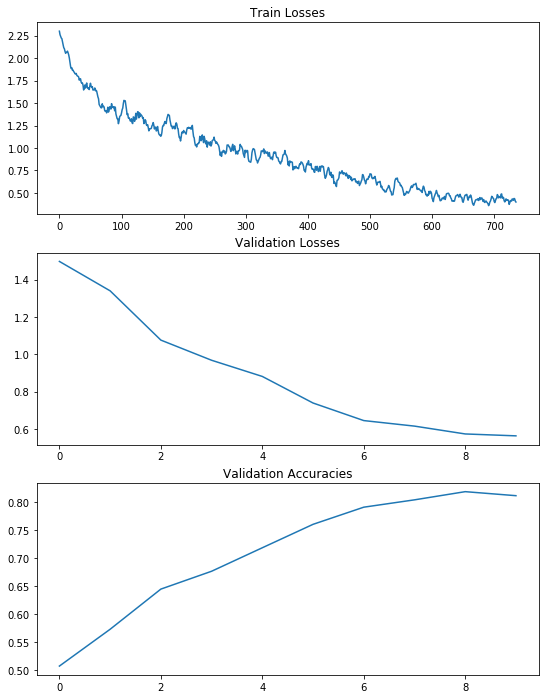

In [9]:
def smooth(vals, length = 5):
    vals = np.array(vals)
    return np.convolve(vals, np.array([1/length] * length), mode = 'valid')

def plot3(losses, val_losses, val_accs):
    fix, ax = plt.subplots(3,1, figsize = (9,12))
    
    ax[0].set_title('Train Losses')
    ax[0].plot(smooth(losses))
    
    ax[1].set_title('Validation Losses')
    ax[1].plot(val_losses)
    
    ax[2].set_title('Validation Accuracies')
    ax[2].plot(val_accs)
    
    plt.show()
    
plot3(losses, val_losses, val_accs)